# Waveform animation script

*Currently a "beta" - just something thrown together as a request for the volc team* 

Takes inputs in the last cell. Have a .py script too which takes user inputs when run in a terminal.

Things to note: 

- Currently configured with the Geonet client rather than nrt - change that field if you want to view waveforms < 7 days old

- At the moment it outputs a figure which is 1280x240 pixels. This can be easily changed with the "figsize" field in the supplots call, but bear in mind you will need to change the position of the annotation too if you want that to stay in a tidy place. 

In [12]:
#importing relevant modules
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.animation import FFMpegWriter
client = Client("GEONET") # change to "http://service-nrt.geonet.org.nz" if looking at recent waveforms

#### Animation function

In [13]:
def waveani(sta, cha, starttime, endtime, filename):
    if cha == "HDF": #avoids using raw HDF channel
        num = 1
    else:
        num = 0
    st = client.get_waveforms(network="NZ", station=sta, channel=cha,
                              location="*", starttime=starttime,
                              endtime=endtime)
    # further slice since obspy automatically pulls more waveforms than you ask for
    st_precise = st[num].slice(starttime=UTCDateTime(starttime),
                               endtime=UTCDateTime(endtime)) 
    y = st_precise[0::4] #quarter the framerate to save processing time
    x = np.arange(len(y))
    fig, ax = plt.subplots(figsize=(12.80, 2.4), dpi = 100)
    p = list(range(len(y)))
    stime = [str(UTCDateTime(starttime) + i/25) for i in p]
    line, = ax.plot([], [], lw=.4)
    annotation = ax.annotate(str(stime[0]), xy=(975, 215),
                             xycoords='figure pixels', fontsize=10)
    annotation.set_animated(True)
    #to try make a symmetrical plot
    if y.max() - y[0] > y[0] - y.min():
        scale = y.max() - y[0] 
    else:
        scale = y[0] - y.min() 
    ax.axis((x.min(), x.max(), y[0] - scale, y[0] + scale))
    #remove xaxis
    ax.axes.get_xaxis().set_visible(False)
    fig.suptitle((sta + " " + cha + " Plot"), y=0.99, fontsize=9.5)
    fig.tight_layout()

    #creating blank plot to draw on
    def init():
        line.set_data([], [])
        return line, annotation

    #creating animation 
    def animate(i):
        line.set_data(x[:i], y[:i])
        annotation.set_text(stime[i])
    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(y),
                                  interval=25, blit=False)
    #writing and saving. Can change .mp4 to desired file format.
    writer = FFMpegWriter(fps=25, bitrate=1800)
    ani.save((filename + ".mp4"), writer=writer)

### Function call - edit values below

Station and codes must be capitalized, and dates should be in yyyy-mm-dd hh:mm:ss format. There is no need to specify .mp4 in the file name as that is already defined in the function.


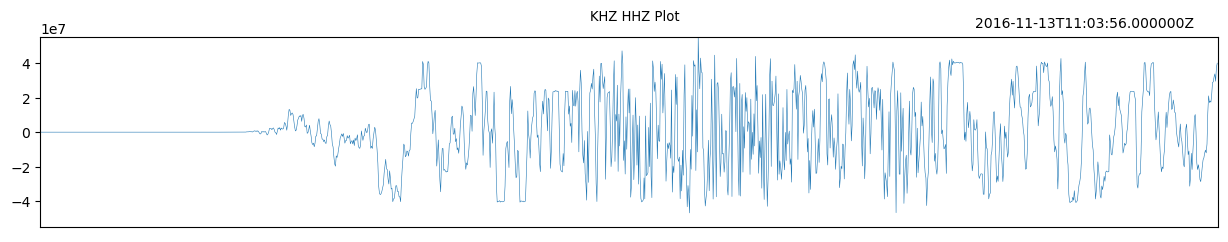

In [14]:
waveani("KHZ", "HHZ", "2016-11-13 11:02:56", "2016-11-13 11:03:56", "Kaikoura_test")